In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile

In [3]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=4)
backend_options = {"method": "statevector"}

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

features, labels = load_iris(return_X_y=True)

In [5]:
dim = features.shape[1]
num_classes = len(set(labels))

In [6]:
print(f"dimension: {dim}, classes: {num_classes}")

dimension: 4, classes: 3


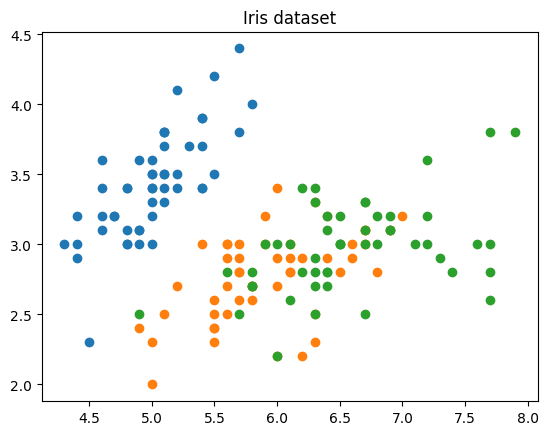

In [7]:
for k in range(0, num_classes):
    plt.scatter(features[labels == k, 0][:features.shape[0]], features[labels == k, 1][:features.shape[0]])
    plt.title("Iris dataset")
plt.show()

In [8]:
features = MinMaxScaler().fit_transform(features)

In [9]:
labels = np.array(labels)
ohe_transformer = OneHotEncoder()
labels = ohe_transformer.fit_transform(labels.reshape(-1,1)).toarray()

In [10]:
algorithm_globals.random_seed = 123
train_size = 0.8
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [11]:
train_features_size = train_features.shape[0]
test_features_size = test_features.shape[0]

In [12]:
print(f"train size: {train_features_size}, test size: {test_features_size}")

train size: 120, test size: 30


In [13]:
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [14]:
optimizer = SPSA(maxiter=200)
feature_map = ZZFeatureMap(feature_dimension=dim, reps=1)
var_form = TwoLocal(dim, ['ry', 'rz'], 'cz', reps=4, entanglement='circular')
sampler = Sampler(backend=backend)

feature_map = transpile(feature_map, backend=backend)
var_form = transpile(var_form, backend=backend)

vqc = VQC(optimizer = optimizer, feature_map = feature_map, ansatz=var_form, loss="cross_entropy", callback=callback_graph, sampler=sampler)

/tmp/ipykernel_967/602918923.py:4: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(backend=backend)


In [15]:
vqc.circuit.draw(output='mpl')

ValueError: Image size of 2247x128376 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2247.21x128376 with 1 Axes>

In [16]:
vqc.feature_map.decompose().draw(output='mpl')

ValueError: Image size of 2247x85567 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2247.21x85567.6 with 1 Axes>

In [17]:
vqc.ansatz.decompose().draw(output='mpl')

ValueError: Image size of 2247x160483 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2247.21x160483 with 1 Axes>

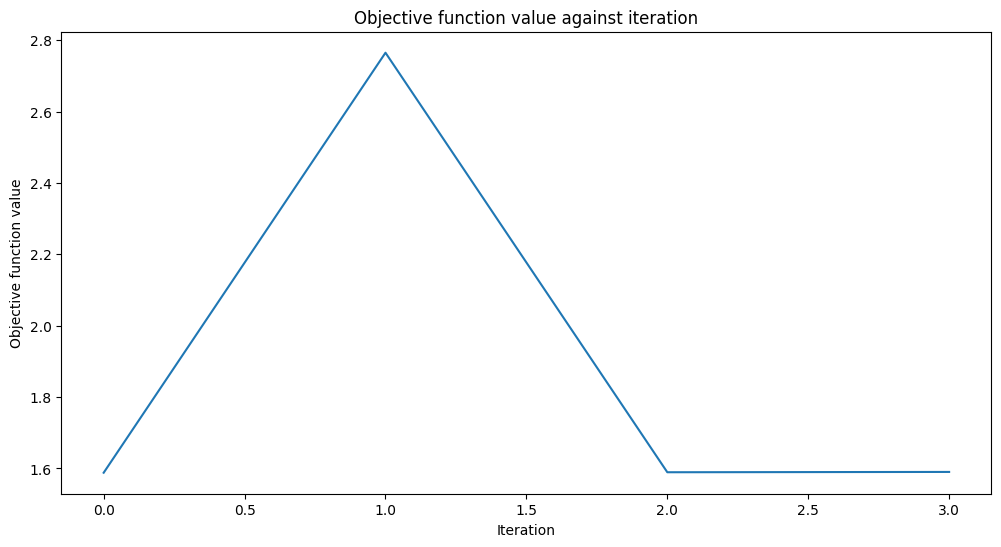

IBMRuntimeError: 'Failed to run program: \'403 Client Error: Forbidden for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"message":"Job create exceeds open plan job usage limits","code":4317,"solution":"Please wait until the beginning of next month to submit more jobs when your quota will reset.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [18]:
%%time
vqc.fit(train_features, train_labels)

In [19]:
vqc.score(train_features, train_labels)

QiskitMachineLearningError: 'The model has not been fitted yet'

In [ ]:
vqc.score(test_features, test_labels)